#  Лабораторная работа №1

_по курсу: "Стеганография"_

_Кривич Максим, КБ-41_

_Харьков - 2017г._

### Задание 1: Реализация алгоритмов встраивания и извлечения сообщений в пространственной области неподвижных изображений методом LSB

In [1]:
import math
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
# Константы
marker = '$stegano_marker$'
text_file = 'random_text.txt'
input_image_file = 'image_{}.bmp'
output_image_file = 'stegano_task{}.bmp'

In [3]:
def container_iter(container):
    for conx in range(0, len(container)):
        for cony in range(0, len(container[conx])):
            yield (container[conx, cony], conx, cony)

In [4]:
def chunks(l, n, step=3):
    for i in range(0, len(l) - n + 1, step):
        yield l[i:i + n]

In [5]:
def string_decode(input, length=8):
    input_l = [input[i:i+length] for i in range(0,len(input),length)]
    return ''.join([chr(int(c,base=2)) for c in input_l])

In [6]:
def lsb_encoder(img, message, bit=0):
    secret_message = ''.join(bin(ord(x))[2:].zfill(8) for x in marker + message + marker)
    container = np.array(img)
    if len(secret_message) // 8 > 3 * 8 * len(container) * len(container[0]): # bytes check
        raise ValueError('Secret message can\'t encoded in image!')
    
    con_iter = container_iter(container)
    res = np.copy(container)
    
    ubit = 1 << bit
    
    for _oct in chunks(secret_message, 3):
        try:
            pix = next(con_iter)
        except StopIteration:
            break
        r, g, b = (pix[0][0], pix[0][1], pix[0][2])
#         print (r,g,b,_oct)
        
        if _oct[0] == "0":
            if r & ubit:
                r = r ^ ubit
        else:
            if not (r & ubit):
                r = r | ubit
            
        if _oct[1] == "0":
            if g & ubit:
                g = g ^ ubit
        else:
            if not (g & ubit):
                g = g | ubit
                    
        if _oct[2] == "0":
            if b & ubit:
                b = b ^ ubit
        else:
            if not (b & ubit):
                b = b | ubit
            
#         print (r,g,b, _oct)
#         print('-'*10)
        res[pix[1], pix[2]] = (r, g, b)
    return res

In [7]:
def lsb_decoder(img , bit=0):
    container = np.array(img)
    bin_str = []
    ubit = 1 << bit
    for pix in container_iter(container):
        r, g, b = (pix[0][0], pix[0][1], pix[0][2])
        bin_str.extend([str(r & ubit), str(g & ubit), str(b & ubit)])
    bin_str = ''.join(bin_str)
    bin_str = string_decode(bin_str).strip(marker)
    return str(bin_str[:bin_str.find(marker)])

In [8]:
def read_file(filename):
    with open(filename, 'r') as f:
        return f.read()

#### Запуск процесса кодирования

In [9]:
new = Image.fromarray(lsb_encoder(Image.open(input_image_file.format(1)), read_file(text_file)))
new.save(output_image_file.format(1))

##### Исходное изображение

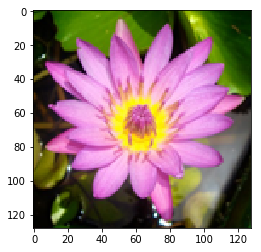

In [10]:
plt.imshow(Image.open(input_image_file.format(1)))
plt.show()

##### Новое закодированное изображение

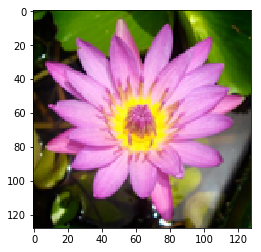

In [11]:
plt.imshow(new)
plt.show()

##### Общий вид измененного файла по отношению к оригиналу

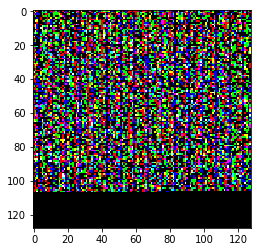

In [12]:
diff = Image.fromarray(np.array(new)-np.array(Image.open(input_image_file.format(1))))
plt.imshow(diff)
plt.show()

##### Получаем закодированное сообщение

In [13]:
new = Image.open(output_image_file.format(1))
print(lsb_decoder(new)[:100])

Sudden she seeing garret far regard. By hardly it direct if pretty up regret. Ability thought enquir


### Задание 2: Реализация алгоритмов встраивания и извлечения сообщений методом псевдослучайной перестановки

In [14]:
def tc_encrypt(key, message):
    ciphertext = [''] * key
    for col in range(key):
        pointer = col   
        while pointer < len(message):
            ciphertext[col] += message[pointer]
            pointer += key
    return''.join(ciphertext)

In [15]:
def tc_decrypt(key, message):
    columns = math.ceil(len(message) / key)
    rows = key
    s_boxes = (columns * rows) - len(message)
    plaintext = [''] * columns
    col = 0
    row = 0
    for symbol in message:
        plaintext[col] += symbol
        col += 1
        if (col == columns) or (col == columns - 1 and row >= rows - s_boxes):
            col = 0
            row += 1
    return ''.join(plaintext)

#### Запуск процесса шифрования и кодирования

##### Исходное изображение

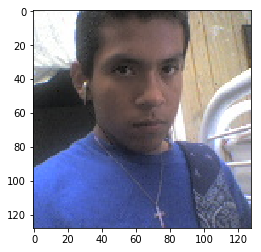

In [16]:
plt.imshow(Image.open(input_image_file.format(2)))
plt.show()

##### Новое закодированное изображение

Cipher text: Mmihesfesa v  t  txKitb tb!ircheohe


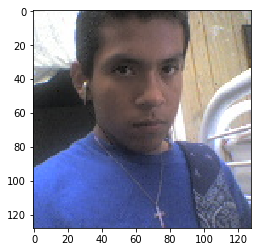

In [17]:
ciphertext = tc_encrypt(4, 'Maxim Krivich the best of the best!')
print('Cipher text: ' + ciphertext)

new = Image.fromarray(lsb_encoder(Image.open(input_image_file.format(2)), ciphertext))
new.save(output_image_file.format(2))

plt.imshow(new)
plt.show()

##### Получаем закодированное сообщение (правильный ключ)

In [18]:
new = Image.open(output_image_file.format(2))
plaintext = tc_decrypt(4, lsb_decoder(new))
print('Plain text: ' + plaintext)

Plain text: Maxim Krivich the best of the best!


##### Получаем закодированное сообщение (неправильный ключ)

In [19]:
new = Image.open(output_image_file.format(2))
plaintext = tc_decrypt(2, lsb_decoder(new))
print('Plain text: ' + plaintext)

Plain text: MxmKiihtebs ftebs!ai rvc h eto h et


In [20]:
def p_encrypt(message, key, n):
    secret_message = ''.join(bin(ord(x))[2:].zfill(8) for x in marker + message + marker)
    ciphertext = ''
    for chnk in chunks(secret_message, n, n):
        m = np.array([int(i) for i in chnk]).T
        ciphertext += str(m.dot(key)).replace(' ', '')[1:-1]
    return string_decode(ciphertext)

In [21]:
def p_decrypt(message, key, n):
    message = ''.join(bin(ord(x))[2:].zfill(8) for x in message)
    plaintext = ''
    for chnk in chunks(message, n, n):
        m = np.array([int(i) for i in chnk]).T
        plaintext += str(m.dot(key.T)).replace(' ', '')[1:-1]
    
    res = string_decode(plaintext)
    if marker in res:
        return res.strip(marker)
    else:
        return 'None'

#### Запуск процесса шифрования и кодирования

In [22]:
key = np.array([[0,1,0,0,0],[1,0,0,0,0],[0,0,0,0,1],[0,0,1,0,0],[0,0,0,1,0]])
ciphertext = p_encrypt('Maxim Krivich cryptographer!', np.array(key), 5)
img = Image.open(input_image_file.format(4))
img = Image.fromarray(lsb_encoder(img, ciphertext))
img.save(output_image_file.format(4))

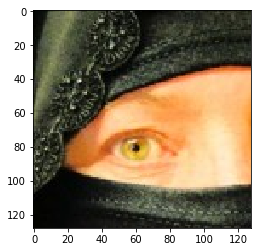

In [23]:
plt.imshow(img)
plt.show()

##### Получаем закодированное сообщение (правильный ключ)

In [24]:
new = Image.open(output_image_file.format(4))
plaintext = p_decrypt(lsb_decoder(new), key, 5)
print('Plain text: ' + plaintext)

Plain text: Maxim Krivich cryptographer!


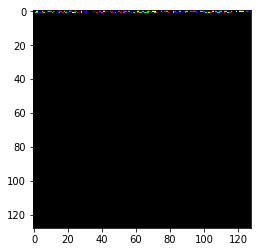

In [25]:
diff = Image.fromarray(np.array(new)-np.array(Image.open(input_image_file.format(4))))
plt.imshow(diff)
plt.show()

##### Получаем закодированное сообщение (неправильный ключ)

In [26]:
new = Image.open(output_image_file.format(4))
key = np.array([[0,0,0,0,1],[1,0,0,0,0],[0,1,0,0,0],[0,0,1,0,0],[0,0,0,1,0]])
plaintext = p_decrypt(lsb_decoder(new), key, 5)
print('Plain text: ' + plaintext)

Plain text: None


### Задание 3: Экспериментальные исследования зрительного порога чувствительности человека к изменению яркости изображений

##### Записываем на место первого бита

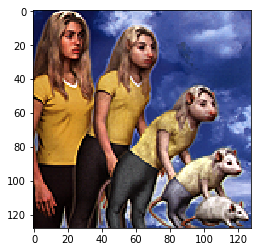

In [27]:
img = Image.open(input_image_file.format(3))
text = read_file(text_file)
img = Image.fromarray(lsb_encoder(img, text, bit=0))
plt.imshow(img)
plt.show()

##### Записываем на место второго бита

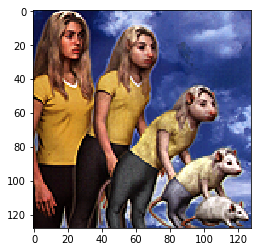

In [28]:
img = Image.fromarray(lsb_encoder(img, text, bit=1))
plt.imshow(img)
plt.show()

##### Записываем на место третьего бита (уже заметны изменения)

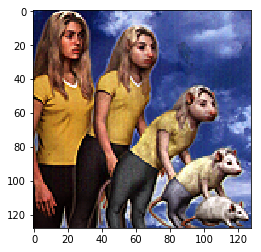

In [29]:
img = Image.fromarray(lsb_encoder(img, text, bit=2))
plt.imshow(img)
plt.show()

##### Записываем на место четвертого бита

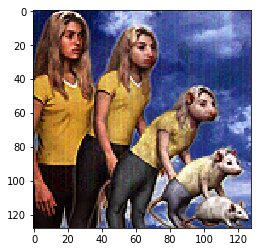

In [30]:
img = Image.fromarray(lsb_encoder(img, text, bit=3))
plt.imshow(img)
plt.show()

##### Записываем на место пятого бита

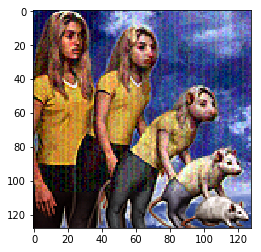

In [31]:
img = Image.fromarray(lsb_encoder(img, text, bit=4))
plt.imshow(img)
plt.show()

__Вывод к заданию:__
Выполняя данное задния я експериментально доказал, что для незаметного сокрытия факта наличия информации достаточно использовать от 1 до 3 наименее значемых бит, иначе можно будет невооруженным глазом заметить нехарактерные изменения в показателях изображения (яркость, насыщенность, и так далее).

L = (2^0+ 2^1 + 2^2) / (2^8) * 100% = 2,73% - использование 3 НЗБ находится пороге чувствительности человеческого зрения

### Задание 4: Реализация алгоритмов встраивания и извлечения сообщений методом псевдослучайного интервала

In [32]:
def gen_key(length):
    return np.random.randint(length, size=length)

In [33]:
def key_iter(key):
    for pos in key:
        yield pos

In [34]:
def pri_encode(img, msg, key, bit=0):
    container = np.array(img)
    secret = ''.join(bin(ord(x))[2:].zfill(8) for x in msg + '$$')

    if len(key) != len(container):
        raise ValueError('Please check key or image!')

    if len(secret) > len(key):
        raise ValueError('')
    
    iter_k = key_iter(key)
    i = 0
    res = np.copy(container)
    ubit = 1 << bit
    
    for _oct in chunks(secret, 3):
        try:
            k = next(iter_k)
        except StopIteration:
            break
        
        r, g, b = (container[i][k][0], container[i][k][1], container[i][k][2])
        if _oct[0] == "0":
            if r & ubit:
                r = r ^ ubit
        else:
            if not (r & ubit):
                r = r | ubit
            
        if _oct[1] == "0":
            if g & ubit:
                g = g ^ ubit
        else:
            if not (g & ubit):
                g = g | ubit
                    
        if _oct[2] == "0":
            if b & ubit:
                b = b ^ ubit
        else:
            if not (b & ubit):
                b = b | ubit
        res[i, k] = (r, g, b)
        i += 1
    return res
        

In [35]:
def pri_decode(img, key, bit=0):
    container = np.array(img)
    bin_str = []
    ubit = 1 << bit
    for i, j in zip([i for i in range(len(key))], key):
        r, g, b = (container[i, j][0], container[i, j][1], container[i, j][2])
        bin_str.extend([str(r & ubit), str(g & ubit), str(b & ubit)])
    bin_str = ''.join(bin_str)
    bin_str = string_decode(bin_str).strip('$')
    return str(bin_str[:bin_str.find('$')])

#### Запуск процесса шифрования и кодирования

In [36]:
img = Image.open(input_image_file.format(5))
key = gen_key(len(np.array(img)))

new = pri_encode(img, 'Max Krivich!', key)

##### Новое закодированное изображение

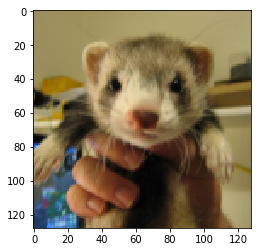

In [37]:
plt.imshow(new)
plt.show()

##### Получаем закодированное сообщение (правильный ключ)

In [38]:
print(pri_decode(new, key))

Max Krivich!


##### Получаем закодированное сообщение (неправильный ключ)

In [39]:
print(pri_decode(new, gen_key(len(np.array(img)))))

Æ_J0s»4§qu³ÿ³~K¸¼³


##### Общий вид измененного файла по отношению к оригиналу

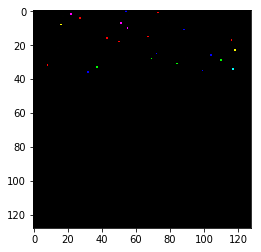

In [40]:
diff = Image.fromarray(np.array(new)-np.array(Image.open(input_image_file.format(5))))
plt.imshow(diff)
plt.show()